In [152]:
# Import necessary libraries
import pandas as pd
import re

# Load the emission factors dataset
def load_emission_factors(filepath):
    """
    Load the emission factors dataset from the given file path.
    Validates the presence of required columns.
    
    Parameters:
        filepath (str): Path to the emission factors file.
    
    Returns:
        DataFrame: Loaded dataset with emission factors.
    """
    try:
        data = pd.read_excel(filepath)
        required_columns = ['Activity', 'Unit', 'CO₂ Emission Factor (kg CO₂/unit)']
        missing_columns = [col for col in required_columns if col not in data.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        return data
    except Exception as e:
        raise FileNotFoundError(f"Error loading dataset: {str(e)}")

# Load dataset
emission_factors = load_emission_factors('Updated_CO2_Emission_Factors.xlsx')
emission_factors


,Activity,Unit,CO₂ Emission Factor (kg CO₂/unit),Region,Source
0,driving,1 km,0.24,Global,UK GHG Conversion Factors 2020
1,bus travel,1 km,0.27,Global,UK GHG Conversion Factors 2020
2,cycling,1 km,0.016,Global,UK GHG Conversion Factors 2020
3,public transport,1 passenger km,0.041,Global,UK GHG Conversion Factors 2020
4,air travel,1 km,0.15,Global,UK GHG Conversion Factors 2020
5,electricity usage,1 passenger km,0.103,Global,UK GHG Conversion Factors 2020
6,heating,1 kWh,0.185,Global,Carbon Trust
7,refrigerator,1 day,0.14,Global,Carbon Trust
8,air conditioner,1 hour,0.32,Global,Carbon Trust
9,using a laptop,1 hour,0.015,Global,Carbon Trust


In [153]:
specific_keywords = {
    # Travel and Transport
    "flight": "air travel",
    "fly": "air travel",
    "electric car": "electric vehicle travel",
    "ev": "electric vehicle travel",
    "train": "train travel",
    "rail": "train travel",
    "metro": "metro travel",
    "drive": "driving",
    "drove": "driving",
    "car": "driving",
    "bus": "bus travel",
    "coach": "bus travel",
    "cycle": "cycling",
    "bicycle": "cycling",
    "bike": "cycling",
    "walk": "walking",
    "walking": "walking",

    # Energy Consumption
    "electricity": "electricity usage",
    "power consumption": "electricity usage",
    "energy consumption": "electricity usage",
    "ac": "air conditioner",
    "air conditioner": "air conditioner",
    "heater": "heating usage",
    "heating": "heating usage",
    "fan": "fan usage",
    "cooling": "fan usage",

    # Cooking and Appliances
    "gas stove": "gas stove usage",
    "oven": "oven usage",
    "microwave": "microwave usage",
    "toaster": "toaster usage",
    "cooking": "cooking gas usage",
    "stove": "cooking gas usage",

    # Water Usage
    "water": "water usage",
    "shower": "shower usage",
    "bath": "bath usage",
    "washing machine": "washing machine usage",
    "laundry": "laundry usage",
    "wash": "laundry usage",

    # Waste Management
    "plastic": "plastic waste management",
    "recycling": "recycling",
    "trash": "trash disposal",
    "waste": "trash disposal",
    "compost": "composting",
    "organic waste": "organic waste management",

    # Miscellaneous
    "light": "lighting usage",
    "bulb": "lighting usage",
    "charging": "device charging",
    "charge": "device charging",
    "phone": "device charging",
    "laptop": "device charging",
    "desktop": "computer usage",
    "computer": "computer usage",
    "printer": "printer usage"
}


In [154]:
import spacy
import re
from spacy.matcher import PhraseMatcher

# Load the SpaCy NLP model
nlp = spacy.load("en_core_web_sm")

# Define a PhraseMatcher for multi-word activities
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")

# Add specific_keywords to the matcher
patterns = [nlp.make_doc(key) for key in specific_keywords.keys()]
matcher.add("ACTIVITY", patterns)

def parse_specific_inputs_with_spacy_and_regex(user_inputs):
    """
    Parse user inputs to extract activities and quantities using SpaCy and regex,
    with additional splitting on 'and' and sentence boundaries.

    Parameters:
        user_inputs (str): User-provided textual description of activities.

    Returns:
        list of dict: Parsed activities with quantities and units.
    """
    parsed_activities = []

    # Split input into sentences using SpaCy
    doc = nlp(user_inputs)

    for sent in doc.sents:  # Process each sentence individually
        # Further split the sentence by "and" to handle multiple activities
        sub_sentences = re.split(r'\s+and\s+', sent.text)

        for sub_sentence in sub_sentences:
            # Extract numeric quantities from the sub-sentence using regex
            quantities = re.findall(r'\b\d+(?:\.\d+)?\b', sub_sentence)
            quantities = [float(q) for q in quantities]

            # Extract activities using PhraseMatcher
            sub_doc = nlp(sub_sentence)
            matches = matcher(sub_doc)
            activities = [specific_keywords[sub_doc[start:end].text.lower()] for _, start, end in matches]

            # Remove duplicates in activities
            activities = list(dict.fromkeys(activities))

            # Debugging outputs for verification
            print(f"Sub-sentence: {sub_sentence.strip()}")
            print(f"Quantities: {quantities}")
            print(f"Activities: {activities}")

            # Pair quantities with activities
            while quantities and activities:
                parsed_activities.append({
                    "activity": activities.pop(0),
                    "quantity": quantities.pop(0)
                })

    return parsed_activities


In [155]:
# User Input Cell
user_input_test = """
I rode my bike for 15 kilometers and then took a bus for 10 kilometers. 
I also used electricity for 200 kWh and ran the air conditioner for 5 hours. 
I cooked using a gas stove for 3 hours and took a bath for 20 minutes.
"""


# Call the parsing function and display the results
parsed_inputs = parse_specific_inputs_with_spacy_and_regex(user_input_test)
parsed_inputs


Sub-sentence: I rode my bike for 15 kilometers
Quantities: [15.0]
Activities: ['cycling']
Sub-sentence: then took a bus for 10 kilometers.
Quantities: [10.0]
Activities: ['bus travel']
Sub-sentence: I also used electricity for 200 kWh
Quantities: [200.0]
Activities: ['electricity usage']
Sub-sentence: ran the air conditioner for 5 hours.
Quantities: [5.0]
Activities: ['air conditioner']
Sub-sentence: I cooked using a gas stove for 3 hours
Quantities: [3.0]
Activities: ['gas stove usage', 'cooking gas usage']
Sub-sentence: took a bath for 20 minutes.
Quantities: [20.0]
Activities: ['bath usage']


[{'activity': 'cycling', 'quantity': 15.0},
 {'activity': 'bus travel', 'quantity': 10.0},
 {'activity': 'electricity usage', 'quantity': 200.0},
 {'activity': 'air conditioner', 'quantity': 5.0},
 {'activity': 'gas stove usage', 'quantity': 3.0},
 {'activity': 'bath usage', 'quantity': 20.0}]

In [156]:
def calculate_emissions(parsed_inputs, emission_factors):
    """
    Calculate carbon emissions based on parsed activities and emission factors.

    Parameters:
        parsed_inputs (list): List of parsed activities with quantities.
        emission_factors (DataFrame): DataFrame containing emission factors.

    Returns:
        list: Activities with their emissions calculated.
        float: Total emissions.
    """
    results = []
    total_emissions = 0

    for entry in parsed_inputs:
        activity = entry["activity"]
        quantity = entry["quantity"]

        # Match the parsed activity with the dataset
        matching_rows = emission_factors[
            emission_factors["Activity"].str.contains(
                f"^{re.escape(activity)}$", case=False, regex=True
            )
        ]

        # Debugging: Print matching details
        print(f"Parsed Activity: {activity}")
        print(f"Matching rows for '{activity}':")
        print(matching_rows)

        # Get the emission factor if available
        if not matching_rows.empty:
            emission_factor = matching_rows["CO₂ Emission Factor (kg CO₂/unit)"].values[0]
        else:
            emission_factor = 0  # Default to 0 if no match found

        # Calculate emissions
        emissions = quantity * emission_factor
        total_emissions += emissions

        # Append results
        results.append({
            "activity": activity,
            "quantity": quantity,
            "emissions": emissions
        })

    return results, total_emissions

In [157]:
# Calculate emissions using the parsed inputs
emission_results, total_emissions = calculate_emissions(parsed_inputs, emission_factors)

# Print the results
print("Emission Results:", emission_results)
print("Total Emissions (kg CO₂):", total_emissions)


Parsed Activity: cycling
Matching rows for 'cycling':
  Activity  Unit CO₂ Emission Factor (kg CO₂/unit)  Region  \
2  cycling  1 km                             0.016  Global   

                           Source  
2  UK GHG Conversion Factors 2020  
Parsed Activity: bus travel
Matching rows for 'bus travel':
     Activity  Unit CO₂ Emission Factor (kg CO₂/unit)  Region  \
1  bus travel  1 km                              0.27  Global   

                           Source  
1  UK GHG Conversion Factors 2020  
Parsed Activity: electricity usage
Matching rows for 'electricity usage':
            Activity            Unit CO₂ Emission Factor (kg CO₂/unit)  \
5  electricity usage  1 passenger km                             0.103   

   Region                          Source  
5  Global  UK GHG Conversion Factors 2020  
Parsed Activity: air conditioner
Matching rows for 'air conditioner':
          Activity    Unit CO₂ Emission Factor (kg CO₂/unit)  Region  \
8  air conditioner  1 hour       

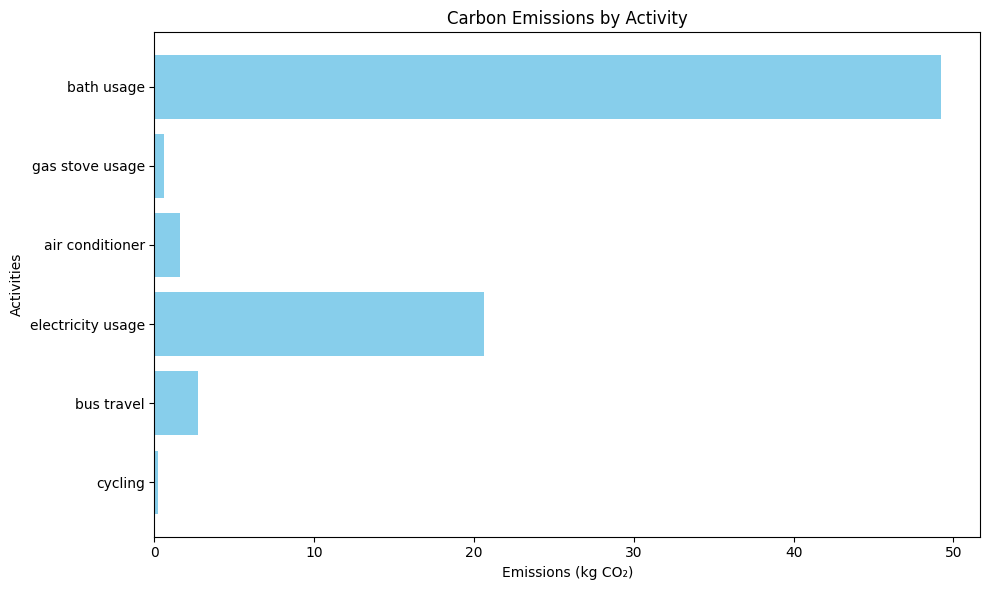

In [158]:
import matplotlib.pyplot as plt

def visualize_emissions(emission_results):
    """
    Visualize emissions by activity as a bar chart.

    Parameters:
        emission_results (list): List of activities with calculated emissions.
    """
    # Extract data for visualization
    activities = [entry["activity"] for entry in emission_results]
    emissions = [entry["emissions"] for entry in emission_results]

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(activities, emissions, color='skyblue')
    plt.xlabel("Emissions (kg CO₂)")
    plt.ylabel("Activities")
    plt.title("Carbon Emissions by Activity")
    plt.tight_layout()
    plt.show()

# Visualize the emission results
visualize_emissions(emission_results)


In [159]:
import pandas as pd

def save_results_to_csv(parsed_inputs, emission_results, total_emissions, filename="emission_results.csv"):
    """
    Save parsed inputs and emission results to a CSV file.

    Parameters:
        parsed_inputs (list): Parsed activities and quantities.
        emission_results (list): Emission results for each activity.
        total_emissions (float): Total carbon emissions.
        filename (str): Filename for saving the CSV.
    """
    # Create a DataFrame for emission results
    results_df = pd.DataFrame(emission_results)

    # Add a total emissions row
    total_row = {"activity": "Total", "quantity": "", "emissions": total_emissions}
    results_df = pd.concat([results_df, pd.DataFrame([total_row])], ignore_index=True)

    # Save to CSV
    results_df.to_csv(filename, index=False)
    print(f"Results saved to {filename}")

# Save the results
save_results_to_csv(parsed_inputs, emission_results, total_emissions)


Results saved to emission_results.csv
